<a href="https://colab.research.google.com/github/vloneonme/trew/blob/main/rabotaet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

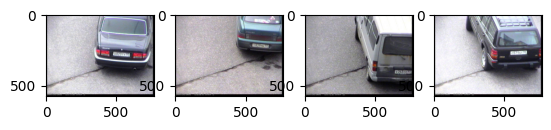

In [ ]:
def load_images():
    filenames = [
        "image/car1.jpg",
        "image/car2.jpg",
        "image/car3.jpg",
        # "image/car4.jpg",
        # "image/car5.jpg",
        # "image/car6.jpg",
        # "image/car7.jpg",
        "image/car8.jpg",
    ]

    images = []
    for filename in filenames:
        image = cv.imread(filename)
        assert image is not None, f"File {filename} could not readable!"
        images.append(image)

    return images


IMAGES = load_images()

def show_car_images():
    figure, axes = plt.subplots(1, len(IMAGES))
    for index, image in enumerate(IMAGES):
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        axes[index].imshow(image)

    plt.show()


show_car_images()

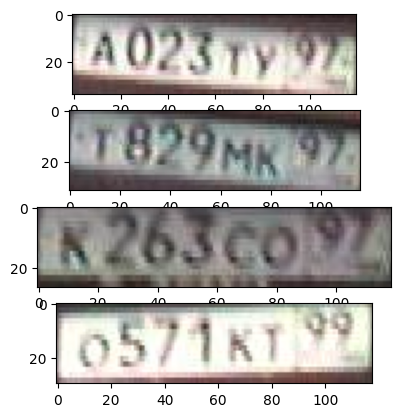

In [ ]:
def find_plate(image):
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, threshold = cv.threshold(gray_image, 0, 255, cv.THRESH_OTSU)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
    threshold = cv.morphologyEx(threshold, cv.MORPH_CLOSE, kernel, iterations=2)
    contours, _ = cv.findContours(threshold, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    image_copy = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    plate = np.zeros((30, 130, 3), dtype=np.uint8)
    result_contour = None

    for cnt in contours:
        x, y, w, h = cv.boundingRect(cnt)

        aspect_ratio = w / h
        area = w * h
        if 3.0 < aspect_ratio < 6.0 and 1000 < area < 5000:
            perimeter = cv.arcLength(cnt, True)
            approx = cv.approxPolyDP(cnt, 0.03 * perimeter, True)
            if len(approx) == 4:
                cv.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

                plate = image[y : y + h, x : x + w]
                result_contour = cnt

    return plate, result_contour

def main():
    _, axes = plt.subplots(len(IMAGES), 1)

    for index, image in enumerate(IMAGES):
        plate, _ = find_plate(image)

        axes[index].imshow(plate, cmap="gray")


main()

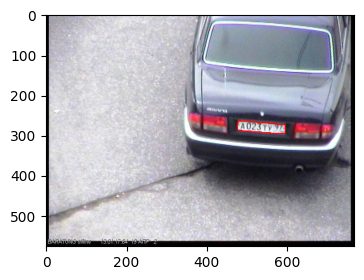

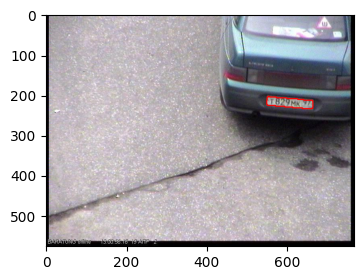

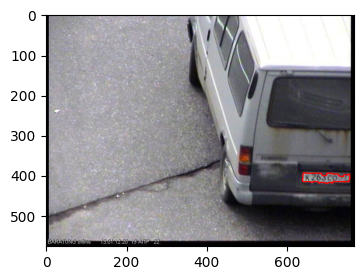

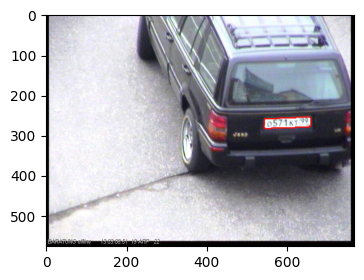

In [ ]:
def main():
    for index, image in enumerate(IMAGES):
        plate, result_contour = find_plate(image)
        copy_image = np.copy(image)
        cv.drawContours(
            copy_image, [result_contour], contourIdx=0, color=(0, 0, 255), thickness=2
        )

        copy_image = cv.cvtColor(copy_image, cv.COLOR_BGR2RGB)
        figure, axe = plt.subplots(figsize=(4, 3))
        axe.imshow(copy_image)


main()

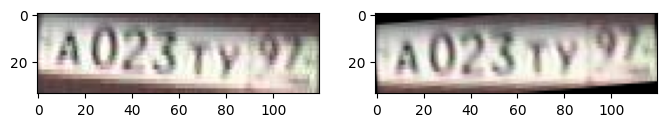

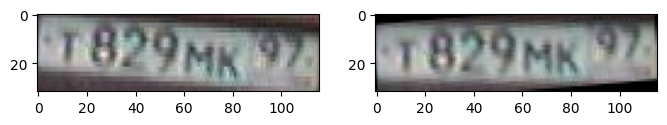

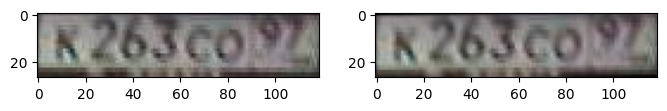

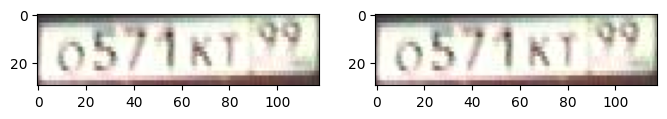

In [ ]:
def rotate_plate(plate, contour):
    result = cv.minAreaRect(contour)
    angle = result[-1]

    angle = 0 if angle >= 85 else angle
    box = cv.boxPoints(result)
    box = np.intp(box)

    rows, cols, _ = plate.shape

    M = cv.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), angle, 1)
    rotated_plate = cv.warpAffine(plate, M, (cols, rows))

    return rotated_plate

def main():
    for image in IMAGES:
        plate, result_contour = find_plate(image)
        rotated_plate = rotate_plate(plate, result_contour)

        figure, axes = plt.subplots(1, 2, figsize=(8, 8))
        axes[0].imshow(plate, cmap="gray")
        axes[1].imshow(rotated_plate, cmap="gray")


main()

In [ ]:
CHARS_IMAGES = {
    os.path.basename(path).split(".")[0].upper(): cv.imread(path)
    for path in glob.glob("chars/*")
}

NUMBERS_IMAGES = {
    os.path.basename(path).split(".")[0].upper(): cv.imread(path)
    for path in glob.glob("numbers/*")
}


def prepare_image(image, width, height, threshold):
    new_size = (width, height)
    image = cv.resize(image, new_size)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, threshold = cv.threshold(image, threshold, 255, cv.THRESH_BINARY)

    return threshold
def plot_prepared_chars():
    char_images = {
        label: prepare_image(image, width=12, height=12, threshold=127)
        for label, image in CHARS_IMAGES.items()
    }

    for index, (label, image) in enumerate(char_images.items()):
        if index == 10:
            figure, axes = plt.subplots(1, 3)
        elif index % 5 == 0:
            figure, axes = plt.subplots(1, 5)

        axes[index % 5].imshow(image, cmap="gray")


def plot_prepared_numbers():
    number_images = {
        label: prepare_image(image, width=15, height=20, threshold=127)
        for label, image in NUMBERS_IMAGES.items()
    }

    for index, (label, image) in enumerate(number_images.items()):
        if index % 5 == 0:
            figure, axes = plt.subplots(1, 5)

        axes[index % 5].imshow(image, cmap="gray")


plot_prepared_chars()
plot_prepared_numbers()

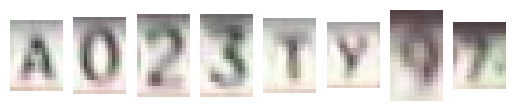

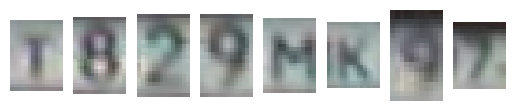

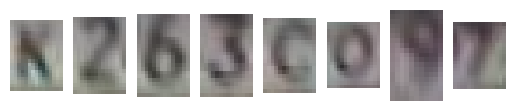

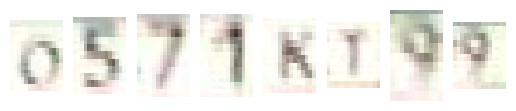

In [ ]:
def cut_signs(plate):
    return [
        plate[6:26, 6:21],
        plate[4:26, 21:36],
        plate[4:26, 34:48],
        plate[4:26, 47:61],
        plate[6:26, 61:75],
        plate[6:26, 74:90],
        plate[1:20, 92:103],
        plate[1:20, 102:117],
    ]


def main():
    for image in IMAGES:
        plate, result_contour = find_plate(image)
        rotated_plate = rotate_plate(plate, result_contour)
        resized_plate = cv.resize(rotated_plate, (120, 30))
        signs = cut_signs(resized_plate)

        figure, axes = plt.subplots(1, len(signs))
        for index, sign in enumerate(signs):
            axes[index].imshow(sign, cmap="gray")
            axes[index].axis("off")


main()

['', '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '']






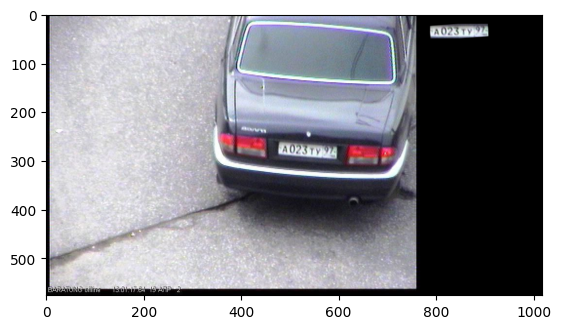

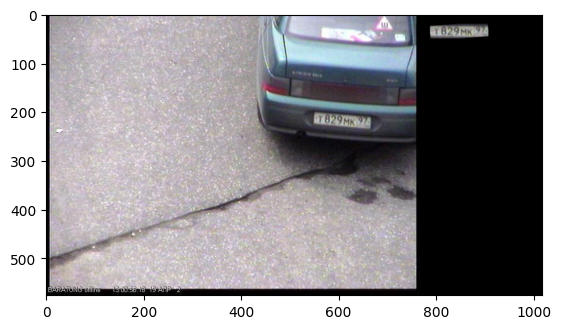

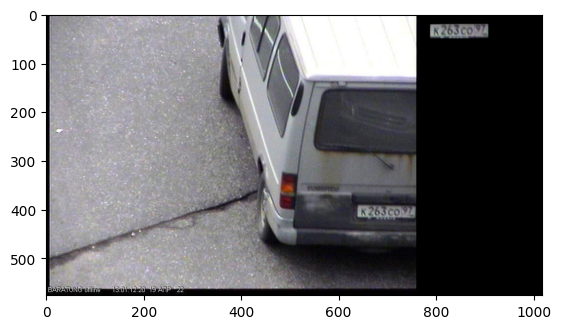

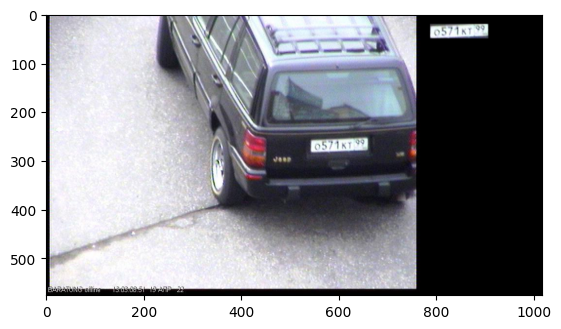

In [ ]:
def prepare_image(image, width, height):
    h, w, _ = image.shape
    fx = (width - 4) / w
    fy = (height - 4) / h
    image = cv.resize(image, None, fx=fx, fy=fy)

    return image

def predict_sign(image, patterns, is_debugging=False):
    height, width, _ = image.shape
    prepared_patterns = {
        label: prepare_image(image, width, height)
        for label, image in patterns.items()
    }

    blurred = cv.GaussianBlur(image, (0, 0), 3)
    sharpened = cv.addWeighted(image, 2.5, blurred, -1.5, 0)

    best_match_value = -1
    best_match_label = None

    values = {}
    if not prepared_patterns: # If patterns are empty, no match can be made
        return '' # Return an empty string instead of None

    for pattern_label, pattern in prepared_patterns.items():
        result = cv.matchTemplate(sharpened, pattern, cv.TM_CCOEFF_NORMED)

        _, max_val, _, _ = cv.minMaxLoc(result)

        values[pattern_label] = max_val

        if max_val > best_match_value:
            best_match_value = max_val
            best_match_label = pattern_label

    if is_debugging:
        print(sorted(values.items(), key=lambda x: x[1], reverse=True))

        figure, axes = plt.subplots(1, 2)
        axes[0].imshow(sharpened)
        axes[1].imshow(prepared_patterns[best_match_label])

    return best_match_label if best_match_label is not None else '' # Return empty string if no match was found


def predict_sings_plate(signs, is_debugging=False):
    predicted_signs = []
    for index, sign in enumerate(signs):
        if index in [0, 4, 5]:
            patterns = CHARS_IMAGES
        else:
            patterns = NUMBERS_IMAGES

        predicted_signs.append(predict_sign(sign, patterns, is_debugging))

    return predicted_signs

def main():
    for image in IMAGES:
        plate, result_contour = find_plate(image)
        rotated_plate = rotate_plate(plate, result_contour)
        resized_plate = cv.resize(rotated_plate, (120, 30))
        signs = cut_signs(resized_plate)
        license_plate = predict_sings_plate(signs, False)

        print(license_plate)


main()

def main():
    for image in IMAGES:
        plate, result_contour = find_plate(image)
        rotated_plate = rotate_plate(plate, result_contour)
        resized_plate = cv.resize(rotated_plate, (120, 30))
        signs = cut_signs(resized_plate)

        license_plate = predict_sings_plate(signs)
        license_plate = "".join(license_plate)
        print(license_plate)

        h, w, c = image.shape
        new_image = np.zeros((h, w + 250, c), dtype=np.uint8)
        new_image[:h, :w] = image[:h, :w]

        hr, wr, cr = resized_plate.shape
        new_image[20 : hr + 20, w + 20 : w + 20 + wr] = resized_plate[:, :]

        cv.putText(
            new_image,
            license_plate,
            (w + 20, 100),
            cv.FONT_HERSHEY_SIMPLEX,
            1,
            (255, 255, 255),
            2,
            cv.LINE_AA,
        )

        new_image = cv.cvtColor(new_image, cv.COLOR_BGR2RGB)
        figure, axe = plt.subplots()
        axe.imshow(new_image)


main()